In [458]:
import os
import pandas as pd
import numpy as np
from glob import glob
import nibabel as nib
from nilearn.plotting import plot_img, plot_stat_map, view_img
from nilearn.image import concat_imgs, mean_img
from nilearn.glm.first_level import FirstLevelModel
from nilearn.glm import threshold_stats_img
import matplotlib.pyplot as plt
from nilearn.plotting import plot_design_matrix
from nilearn.interfaces.fmriprep import load_confounds_strategy


# Homemade functions

In [459]:
# Now open a directory 
fd = os.open("/Users/luisalvarez/Documents/Datasets", os.O_RDONLY)

# Use os.fchdir() method to change the dir/folder
os.fchdir(fd)

# Safe check- Print current working directory
print("Current working dir : %s" % os.getcwd())

Current working dir : /Users/luisalvarez/Documents/Datasets


In [460]:
def create_events_df(participant_raw_events, trials_num, TR):

    run1_events = pd.DataFrame(columns={"onset", "duration", "trial_type"}) 

    for x in range(trials_num): 

        trial_onset = participant_raw_events["onset"][x]
        anticipation_onset = trial_onset + TR/2
        anticipation_duration = 2

        response_onset = trial_onset + participant_raw_events["response_time"][x] + TR/2
        response_duration = 0.5

        outcome_lag = 7
        outcome_onset = trial_onset + outcome_lag + TR/2
        outcome_duration = 2

        current_trial = participant_raw_events["trial_type"][x]
        current_hit = participant_raw_events["hit"][x]
    
        # Determine event type for anticipation period.
        if(current_trial == "-$0"):
            current_trialtype = "nonloss"
            response_trial = "response"
        elif(current_trial == "+$0"):
            current_trialtype = "nongain"
            response_trial = "response"
        elif(current_trial == "+$5"):
            current_trialtype = "large_gain"
            response_trial = "response"
        elif(current_trial == "-$5"):
            current_trialtype = "large_loss"
            response_trial = "response"
        elif(current_trial == "+$1"):
            current_trialtype = "medium_gain"
            response_trial = "response"
        elif(current_trial == "-$1"):
            current_trialtype = "medium_loss"
            response_trial = "response"
        else:
            print(f"There appears to be an error with trial {x}")
    
        if(current_hit == 1):
            #current_trialtype = current_trialtype + "_hit"
            current_outcome_type = "outome_" + current_trialtype 
        else:
            #current_trialtype = current_trialtype + "_miss"
            current_outcome_type = "outome_zero" + "_miss"

        anticipation_data = [[anticipation_onset, anticipation_duration, current_trialtype]]
        current_row = pd.DataFrame(data=anticipation_data, columns=["onset", "duration", "trial_type"]) 
        run1_events = pd.concat([run1_events, current_row], ignore_index=True)

        if(current_hit == 1):
            response_data = [[response_onset, response_duration, response_trial]]
            response_row = pd.DataFrame(data=response_data, columns=["onset", "duration", "trial_type"]) 
            run1_events = pd.concat([run1_events, response_row], ignore_index=True)  
        

        current_outcome_row = pd.DataFrame(data=[[outcome_onset, outcome_duration, current_outcome_type]], columns=["onset", "duration", "trial_type"])
        run1_events = pd.concat([run1_events, current_outcome_row], ignore_index=True)

    return run1_events


In [461]:
def run_FL_GLM(participant_num):
    
    # Load files for sub 00X 
    current_sub_run1_func_file = "MID_preproc2/sub-" + participant_num +"/func/sub-" + participant_num + "_task-MID_run-1_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz"
    current_sub_run1_mask_file = "MID_preproc2/sub-" + participant_num + "/func/sub-"+ participant_num +"_task-MID_run-1_space-MNI152NLin2009cAsym_desc-brain_mask.nii.gz"
    current_sub_file = 'MID_raw/sub-' + participant_num + '/func/sub-' + participant_num + '_task-MID_run-1_events.tsv'
    current_sub_run1_confounds_file = "MID_preproc2/sub-" + participant_num + "/func/sub-" + participant_num + "_task-MID_run-1_desc-confounds_timeseries.tsv"

    # Get some info from the ".nii" file. 
    current_sub_func_file = nib.load(current_sub_run1_func_file)
    current_sub_func_data = current_sub_func_file.get_data()

    print("File of fist run 1 has shape (x, y, z, n_vols) -> %s" % str(current_sub_func_data.shape))
    
    # Load current participants responses file.
    current_sub_events_raw = pd.read_csv(current_sub_file, sep='\t')
    trials_num = current_sub_events_raw.shape[0]

    print(f"run1_events shape: {current_sub_events_raw.shape}")
    print(f"Run 1 number of trials: {trials_num}")

    # Create events dataframe.
    current_sub_events = create_events_df(current_sub_events_raw, trials_num, TR=2)
    print(f"Use the following event regressors: {current_sub_events.trial_type.unique()}")

    # Load raw confounds file. 
    current_sub_confounds_df = pd.read_csv(current_sub_run1_confounds_file, sep='\t')
    default_confounds = ['trans_y', 'trans_x', 'trans_z', 'rot_y', 'rot_x', 'rot_z', "global_signal", "tcompcor", "white_matter", "csf", "csf_wm", "framewise_displacement", "dvars"] # "global_signal",

    # Get motion confounds.
    current_state_confounds = [i for i in current_sub_confounds_df.columns if "state" in i] 
    current_state_confounds = current_state_confounds[0:2]
    current_motion_confounds = [i for i in current_sub_confounds_df.columns if "motion" in i] 

    # Create confounds df.
    current_sub_confounds_df = current_sub_confounds_df[default_confounds + current_motion_confounds] # current_state_confounds +
    current_sub_confounds_df = current_sub_confounds_df.fillna(0) 
    print(f"Use the following confound regressors: {current_sub_confounds_df.columns}")
    
    # Create First Level GLM object.
    fmri_glm = FirstLevelModel(
    t_r=2,
    noise_model="ols",
    standardize=True,
    hrf_model="spm",
    drift_model="cosine",
    high_pass= 0.011,
    slice_time_ref=0.5, 
    mask_img=current_sub_run1_mask_file,
    smoothing_fwhm = 4)

    # Fit GLM object to participants data.
    fmri_glm = fmri_glm.fit(current_sub_run1_func_file, current_sub_events, current_sub_confounds_df)

    anticipation_gain_contrast = "+1*large_gain+1*+1*medium_gain+1*-2*nongain"
    #anticipation_gain_contrast = "+1*large_gain_hit+1*large_gain_miss+1*medium_gain_hit+1*medium_gain_miss-2*nongain_hit-2*nongain_miss"

    anticipation_gain_z_map = fmri_glm.compute_contrast(contrast_def=anticipation_gain_contrast, output_type="z_score")

    anticipation_gain_thresholded_map, threshold = threshold_stats_img(anticipation_gain_z_map, alpha=0.05, height_control="fdr", cluster_threshold=0)
    print(f"FDR p<0.05 threshold: {threshold:.3f}")
    plot_stat_map(
    anticipation_gain_thresholded_map,
    threshold=threshold,
    cut_coords=[15, 14, -5],
    black_bg=True,
    title=str("Participant " + participant_num + ": Gain vs. Nongain Anticipation"))
    plt.show()

    
    

/var/folders/0z/1yt2h6410kb7_mgghf4q28z00000gn/T/ipykernel_17778/496869419.py:11: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  current_sub_func_data = current_sub_func_file.get_data()


File of fist run 1 has shape: (58, 69, 58, 442)
run1_events shape: (72, 9)
Run 1 number of trials: 72
Use the following event regressors: ['nonloss' 'outome_zero_miss' 'medium_loss' 'response'
 'outome_medium_loss' 'nongain' 'outome_nongain' 'large_gain' 'large_loss'
 'outome_large_loss' 'medium_gain' 'outome_medium_gain' 'outome_nonloss'
 'outome_large_gain']
Use the following confound regressors: Index(['trans_y', 'trans_x', 'trans_z', 'rot_y', 'rot_x', 'rot_z', 'tcompcor',
       'white_matter', 'csf', 'csf_wm', 'framewise_displacement', 'dvars',
       'motion_outlier00', 'motion_outlier01', 'motion_outlier02',
       'motion_outlier03'],
      dtype='object')
FDR p<0.05 threshold: 3.163


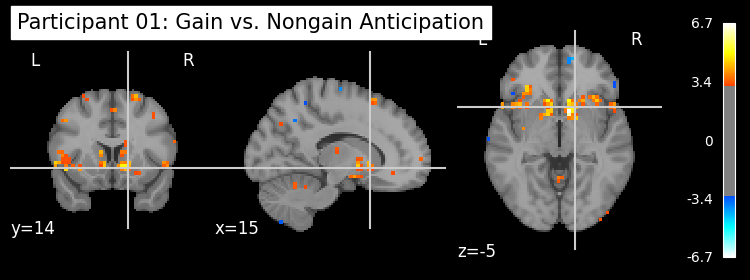

In [462]:
run_FL_GLM("01")

/var/folders/0z/1yt2h6410kb7_mgghf4q28z00000gn/T/ipykernel_17778/496869419.py:11: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  current_sub_func_data = current_sub_func_file.get_data()


File of fist run 1 has shape: (58, 69, 58, 442)
run1_events shape: (72, 9)
Run 1 number of trials: 72
Use the following event regressors: ['nonloss' 'response' 'outome_nonloss' 'medium_loss' 'outome_medium_loss'
 'nongain' 'outome_nongain' 'large_gain' 'outome_large_gain'
 'outome_zero_miss' 'large_loss' 'outome_large_loss' 'medium_gain'
 'outome_medium_gain']
Use the following confound regressors: Index(['trans_y', 'trans_x', 'trans_z', 'rot_y', 'rot_x', 'rot_z', 'tcompcor',
       'white_matter', 'csf', 'csf_wm', 'framewise_displacement', 'dvars',
       'motion_outlier00', 'motion_outlier01', 'motion_outlier02',
       'motion_outlier03', 'motion_outlier04'],
      dtype='object')
FDR p<0.05 threshold: 3.153


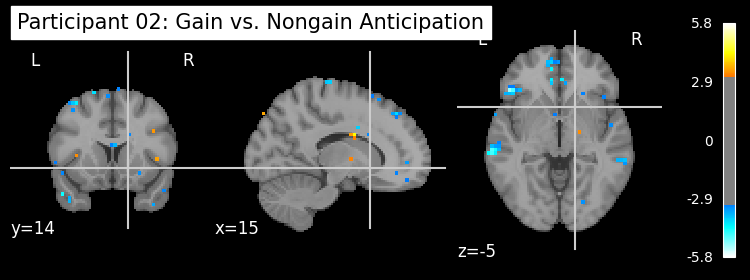

In [463]:
run_FL_GLM("02")

/var/folders/0z/1yt2h6410kb7_mgghf4q28z00000gn/T/ipykernel_17778/496869419.py:11: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  current_sub_func_data = current_sub_func_file.get_data()


File of fist run 1 has shape: (58, 69, 58, 442)
run1_events shape: (72, 9)
Run 1 number of trials: 72
Use the following event regressors: ['nonloss' 'response' 'outome_nonloss' 'medium_loss' 'outome_medium_loss'
 'nongain' 'outome_nongain' 'large_gain' 'outome_zero_miss' 'large_loss'
 'medium_gain' 'outome_medium_gain' 'outome_large_gain'
 'outome_large_loss']
Use the following confound regressors: Index(['trans_y', 'trans_x', 'trans_z', 'rot_y', 'rot_x', 'rot_z', 'tcompcor',
       'white_matter', 'csf', 'csf_wm', 'framewise_displacement', 'dvars',
       'motion_outlier00', 'motion_outlier01'],
      dtype='object')
FDR p<0.05 threshold: 3.053


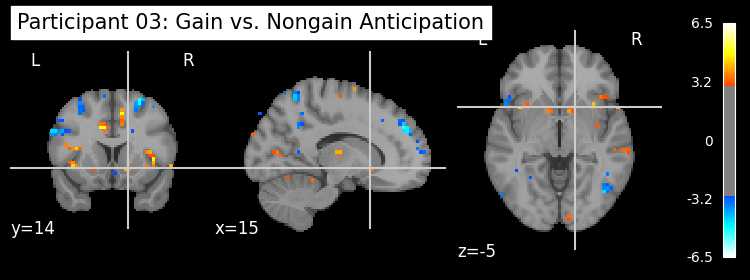

In [464]:
run_FL_GLM("03")

/var/folders/0z/1yt2h6410kb7_mgghf4q28z00000gn/T/ipykernel_17778/496869419.py:11: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  current_sub_func_data = current_sub_func_file.get_data()


File of fist run 1 has shape: (58, 69, 58, 442)
run1_events shape: (72, 9)
Run 1 number of trials: 72
Use the following event regressors: ['nonloss' 'outome_zero_miss' 'medium_loss' 'response'
 'outome_medium_loss' 'nongain' 'outome_nongain' 'large_gain'
 'outome_large_gain' 'large_loss' 'outome_large_loss' 'medium_gain'
 'outome_medium_gain' 'outome_nonloss']
Use the following confound regressors: Index(['trans_y', 'trans_x', 'trans_z', 'rot_y', 'rot_x', 'rot_z', 'tcompcor',
       'white_matter', 'csf', 'csf_wm', 'framewise_displacement', 'dvars',
       'motion_outlier00', 'motion_outlier01', 'motion_outlier02',
       'motion_outlier03', 'motion_outlier04'],
      dtype='object')


/Users/luisalvarez/opt/anaconda3/lib/python3.9/site-packages/nilearn/_utils/glm.py:310: UserWarning: Matrix is singular at working precision, regularizing...
  warn('Matrix is singular at working precision, regularizing...')


FDR p<0.05 threshold: 3.347


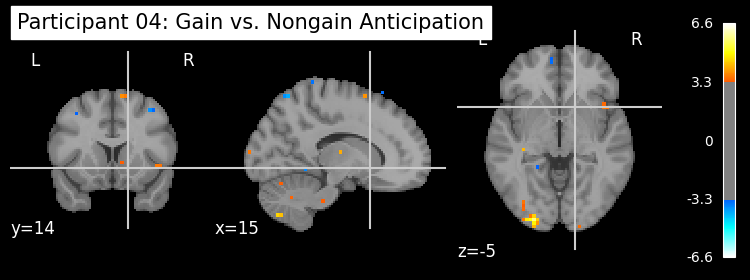

In [465]:
run_FL_GLM("04")

/var/folders/0z/1yt2h6410kb7_mgghf4q28z00000gn/T/ipykernel_17778/496869419.py:11: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  current_sub_func_data = current_sub_func_file.get_data()


File of fist run 1 has shape: (58, 69, 58, 442)
run1_events shape: (72, 9)
Run 1 number of trials: 72
Use the following event regressors: ['nonloss' 'response' 'outome_nonloss' 'medium_loss' 'outome_medium_loss'
 'nongain' 'outome_nongain' 'large_gain' 'outome_large_gain' 'large_loss'
 'outome_large_loss' 'medium_gain' 'outome_medium_gain' 'outome_zero_miss']
Use the following confound regressors: Index(['trans_y', 'trans_x', 'trans_z', 'rot_y', 'rot_x', 'rot_z', 'tcompcor',
       'white_matter', 'csf', 'csf_wm', 'framewise_displacement', 'dvars',
       'motion_outlier00', 'motion_outlier01', 'motion_outlier02',
       'motion_outlier03', 'motion_outlier04'],
      dtype='object')
FDR p<0.05 threshold: 2.795


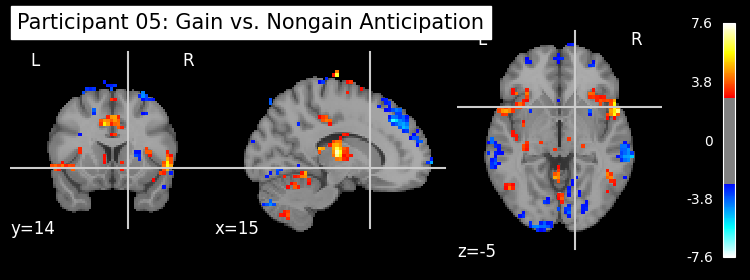

In [466]:
run_FL_GLM("05")

/var/folders/0z/1yt2h6410kb7_mgghf4q28z00000gn/T/ipykernel_17778/496869419.py:11: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  current_sub_func_data = current_sub_func_file.get_data()


File of fist run 1 has shape: (58, 69, 58, 442)
run1_events shape: (72, 9)
Run 1 number of trials: 72
Use the following event regressors: ['nonloss' 'response' 'outome_nonloss' 'medium_loss' 'outome_medium_loss'
 'nongain' 'outome_nongain' 'large_gain' 'outome_large_gain' 'large_loss'
 'outome_large_loss' 'medium_gain' 'outome_medium_gain' 'outome_zero_miss']
Use the following confound regressors: Index(['trans_y', 'trans_x', 'trans_z', 'rot_y', 'rot_x', 'rot_z', 'tcompcor',
       'white_matter', 'csf', 'csf_wm', 'framewise_displacement', 'dvars',
       'motion_outlier00', 'motion_outlier01', 'motion_outlier02',
       'motion_outlier03', 'motion_outlier04', 'motion_outlier05',
       'motion_outlier06', 'motion_outlier07', 'motion_outlier08',
       'motion_outlier09', 'motion_outlier10'],
      dtype='object')
FDR p<0.05 threshold: 2.903


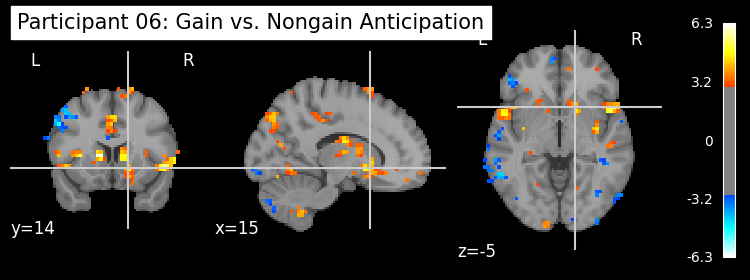

In [467]:
run_FL_GLM("06")

/var/folders/0z/1yt2h6410kb7_mgghf4q28z00000gn/T/ipykernel_17778/496869419.py:11: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  current_sub_func_data = current_sub_func_file.get_data()


File of fist run 1 has shape: (58, 69, 58, 442)
run1_events shape: (72, 9)
Run 1 number of trials: 72
Use the following event regressors: ['nonloss' 'response' 'outome_nonloss' 'medium_loss' 'outome_medium_loss'
 'nongain' 'outome_zero_miss' 'large_gain' 'outome_large_gain'
 'outome_nongain' 'large_loss' 'outome_large_loss' 'medium_gain'
 'outome_medium_gain']
Use the following confound regressors: Index(['trans_y', 'trans_x', 'trans_z', 'rot_y', 'rot_x', 'rot_z', 'tcompcor',
       'white_matter', 'csf', 'csf_wm', 'framewise_displacement', 'dvars',
       'motion_outlier00', 'motion_outlier01', 'motion_outlier02',
       'motion_outlier03', 'motion_outlier04', 'motion_outlier05'],
      dtype='object')


/Users/luisalvarez/opt/anaconda3/lib/python3.9/site-packages/nilearn/_utils/param_validation.py:72: UserWarning: The given float value must not exceed 4.777646508372989. But, you have given threshold=inf 
  warnings.warn("The given float value must not exceed {0}. "


FDR p<0.05 threshold: inf


/Users/luisalvarez/opt/anaconda3/lib/python3.9/site-packages/nilearn/plotting/displays/_slicers.py:382: UserWarning: empty mask
  get_mask_bounds(new_img_like(img, not_mask, affine))


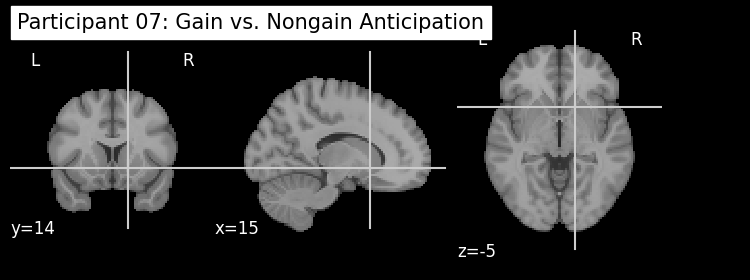

In [468]:
run_FL_GLM("07")

/var/folders/0z/1yt2h6410kb7_mgghf4q28z00000gn/T/ipykernel_17778/496869419.py:11: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  current_sub_func_data = current_sub_func_file.get_data()


File of fist run 1 has shape: (58, 69, 58, 442)
run1_events shape: (72, 9)
Run 1 number of trials: 72
Use the following event regressors: ['nonloss' 'response' 'outome_nonloss' 'medium_loss' 'outome_medium_loss'
 'nongain' 'outome_nongain' 'large_gain' 'outome_large_gain'
 'outome_zero_miss' 'large_loss' 'outome_large_loss' 'medium_gain'
 'outome_medium_gain']
Use the following confound regressors: Index(['trans_y', 'trans_x', 'trans_z', 'rot_y', 'rot_x', 'rot_z', 'tcompcor',
       'white_matter', 'csf', 'csf_wm', 'framewise_displacement', 'dvars',
       'motion_outlier00', 'motion_outlier01'],
      dtype='object')
FDR p<0.05 threshold: 2.864


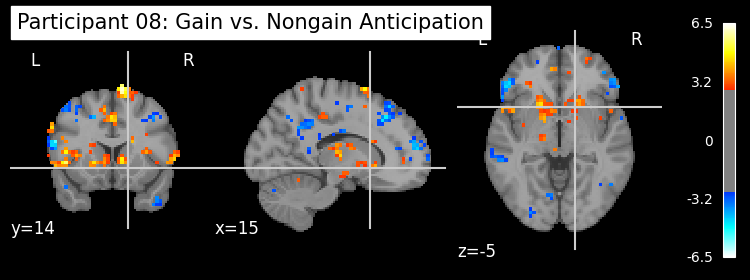

In [469]:
run_FL_GLM("08")

/var/folders/0z/1yt2h6410kb7_mgghf4q28z00000gn/T/ipykernel_17778/496869419.py:11: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  current_sub_func_data = current_sub_func_file.get_data()


File of fist run 1 has shape: (58, 69, 58, 442)
run1_events shape: (72, 9)
Run 1 number of trials: 72
Use the following event regressors: ['nonloss' 'outome_zero_miss' 'medium_loss' 'response'
 'outome_medium_loss' 'nongain' 'outome_nongain' 'large_gain'
 'outome_large_gain' 'large_loss' 'outome_large_loss' 'medium_gain'
 'outome_medium_gain' 'outome_nonloss']
Use the following confound regressors: Index(['trans_y', 'trans_x', 'trans_z', 'rot_y', 'rot_x', 'rot_z', 'tcompcor',
       'white_matter', 'csf', 'csf_wm', 'framewise_displacement', 'dvars',
       'motion_outlier00', 'motion_outlier01', 'motion_outlier02'],
      dtype='object')
FDR p<0.05 threshold: 2.511


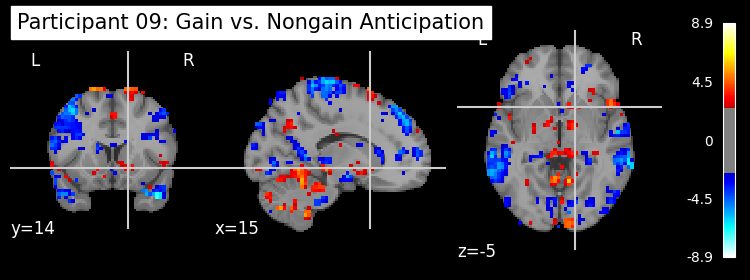

In [470]:
run_FL_GLM("09")

/var/folders/0z/1yt2h6410kb7_mgghf4q28z00000gn/T/ipykernel_17778/496869419.py:11: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  current_sub_func_data = current_sub_func_file.get_data()


File of fist run 1 has shape: (58, 69, 58, 442)
run1_events shape: (72, 9)
Run 1 number of trials: 72
Use the following event regressors: ['nonloss' 'outome_zero_miss' 'medium_loss' 'response'
 'outome_medium_loss' 'nongain' 'outome_nongain' 'large_gain'
 'outome_large_gain' 'large_loss' 'medium_gain' 'outome_medium_gain'
 'outome_nonloss' 'outome_large_loss']
Use the following confound regressors: Index(['trans_y', 'trans_x', 'trans_z', 'rot_y', 'rot_x', 'rot_z', 'tcompcor',
       'white_matter', 'csf', 'csf_wm', 'framewise_displacement', 'dvars',
       'motion_outlier00', 'motion_outlier01'],
      dtype='object')
FDR p<0.05 threshold: 3.779


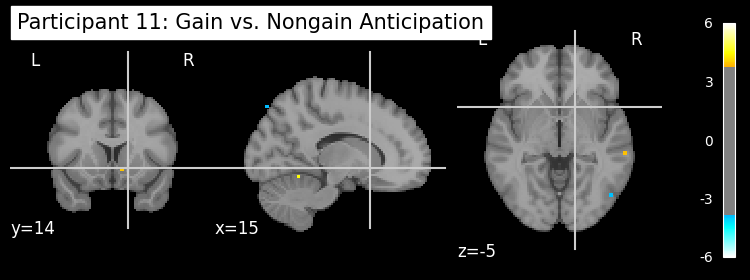

In [471]:
run_FL_GLM("11")

/var/folders/0z/1yt2h6410kb7_mgghf4q28z00000gn/T/ipykernel_17778/496869419.py:11: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  current_sub_func_data = current_sub_func_file.get_data()


File of fist run 1 has shape: (58, 69, 58, 442)
run1_events shape: (72, 9)
Run 1 number of trials: 72
Use the following event regressors: ['nonloss' 'response' 'outome_nonloss' 'medium_loss' 'outome_medium_loss'
 'nongain' 'outome_zero_miss' 'large_gain' 'outome_large_gain'
 'outome_nongain' 'large_loss' 'outome_large_loss' 'medium_gain'
 'outome_medium_gain']
Use the following confound regressors: Index(['trans_y', 'trans_x', 'trans_z', 'rot_y', 'rot_x', 'rot_z', 'tcompcor',
       'white_matter', 'csf', 'csf_wm', 'framewise_displacement', 'dvars',
       'motion_outlier00', 'motion_outlier01', 'motion_outlier02',
       'motion_outlier03', 'motion_outlier04', 'motion_outlier05',
       'motion_outlier06'],
      dtype='object')
FDR p<0.05 threshold: 3.813


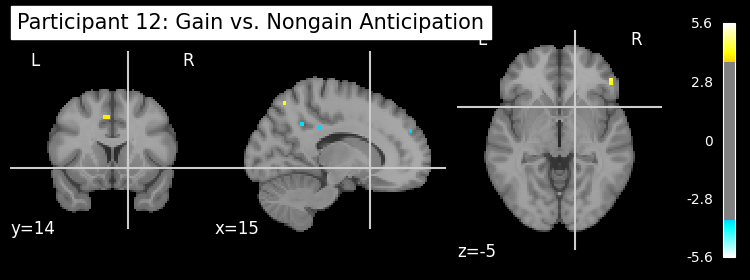

In [472]:
run_FL_GLM("12")